In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import random

In [ ]:
"""
Architecture based on InfoGAN paper.
"""

class Generator(nn.Module):
	def __init__(self):
		super().__init__()

		self.tconv1 = nn.ConvTranspose2d(228, 448, 2, 1, bias=False)
		self.bn1 = nn.BatchNorm2d(448)

		self.tconv2 = nn.ConvTranspose2d(448, 256, 4, 2, padding=1, bias=False)
		self.bn2 = nn.BatchNorm2d(256)

		self.tconv3 = nn.ConvTranspose2d(256, 128, 4, 2, padding=1, bias=False)

		self.tconv4 = nn.ConvTranspose2d(128, 64, 4, 2, padding=1, bias=False)

		self.tconv5 = nn.ConvTranspose2d(64, 3, 4, 2, padding=1, bias=False)

	def forward(self, x):
		x = F.relu(self.bn1(self.tconv1(x)))
		x = F.relu(self.bn2(self.tconv2(x)))
		x = F.relu(self.tconv3(x))
		x = F.relu(self.tconv4(x))

		img = torch.tanh(self.tconv5(x))

		return img

class Discriminator(nn.Module):
	def __init__(self):
		super().__init__()

		self.conv1 = nn.Conv2d(3, 64, 4, 2, 1)

		self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
		self.bn2 = nn.BatchNorm2d(128)

		self.conv3 = nn.Conv2d(128, 256, 4, 2, 1, bias=False)
		self.bn3 = nn.BatchNorm2d(256)

	def forward(self, x):
		x = F.leaky_relu(self.conv1(x), 0.1, inplace=True)
		x = F.leaky_relu(self.bn2(self.conv2(x)), 0.1, inplace=True)
		x = F.leaky_relu(self.bn3(self.conv3(x)), 0.1, inplace=True)

		return x

class DHead(nn.Module):
	def __init__(self):
		super().__init__()

		self.conv = nn.Conv2d(256, 1, 4)

	def forward(self, x):
		output = torch.sigmoid(self.conv(x))

		return output

class QHead(nn.Module):
	def __init__(self):
		super().__init__()

		self.conv1 = nn.Conv2d(256, 128, 4, bias=False)
		self.bn1 = nn.BatchNorm2d(128)

		self.conv_disc = nn.Conv2d(128, 100, 1)

		self.conv_mu = nn.Conv2d(128, 1, 1)
		self.conv_var = nn.Conv2d(128, 1, 1)

	def forward(self, x):
		x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1, inplace=True)

		disc_logits = self.conv_disc(x).squeeze()

		# Not used during training for celeba dataset.
		mu = self.conv_mu(x).squeeze()
		var = torch.exp(self.conv_var(x).squeeze())

		return disc_logits, mu, var

In [ ]:
def weights_init(m):
    """
    Initialise weights of the model.
    """
    if(type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif(type(m) == nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class NormalNLLLoss:
    """
    Calculate the negative log likelihood
    of normal distribution.
    This needs to be minimised.
    Treating Q(cj | x) as a factored Gaussian.
    """
    def __call__(self, x, mu, var):
        
        logli = -0.5 * (var.mul(2 * np.pi) + 1e-6).log() - (x - mu).pow(2).div(var.mul(2.0) + 1e-6)
        nll = -(logli.sum(1).mean())

        return nll

def noise_sample(n_dis_c, dis_c_dim, n_con_c, n_z, batch_size, device):
    """
    Sample random noise vector for training.
    INPUT
    --------
    n_dis_c : Number of discrete latent code.
    dis_c_dim : Dimension of discrete latent code.
    n_con_c : Number of continuous latent code.
    n_z : Dimension of iicompressible noise.
    batch_size : Batch Size
    device : GPU/CPU
    """

    z = torch.randn(batch_size, n_z, 1, 1, device=device)

    idx = np.zeros((n_dis_c, batch_size))
    if(n_dis_c != 0):
        dis_c = torch.zeros(batch_size, n_dis_c, dis_c_dim, device=device)
        
        for i in range(n_dis_c):
            idx[i] = np.random.randint(dis_c_dim, size=batch_size)
            dis_c[torch.arange(0, batch_size), i, idx[i]] = 1.0

        dis_c = dis_c.view(batch_size, -1, 1, 1)

    if(n_con_c != 0):
        # Random uniform between -1 and 1.
        con_c = torch.rand(batch_size, n_con_c, 1, 1, device=device) * 2 - 1

    noise = z
    if(n_dis_c != 0):
        noise = torch.cat((z, dis_c), dim=1)
    if(n_con_c != 0):
        noise = torch.cat((noise, con_c), dim=1)

    return noise, idx

In [ ]:
epochs=200
batch_size=16
learning_rate=2e-4
beta1=0.5
beta2=0.999
check_epoch=[25,50,75,100,125,150,175,200]

In [ ]:
transform = transforms.Compose([
            transforms.Resize(32),
            transforms.CenterCrop(32),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5),
                (0.5, 0.5, 0.5))])

root = '/content/drive/My Drive/data/'
dataset = datasets.ImageFolder(root=root, transform=transform)
subset_train=range(0,1500)
subset_test=range(1500,2000)

dataset_train = torch.utils.data.Subset(dataset, subset_train)
dataset_test = torch.utils.data.Subset(dataset, subset_test)

#Data loader de train y test
dataloader_train = torch.utils.data.DataLoader(dataset_train, 
                                              batch_size=batch_size, 
                                              shuffle=True)

dataloader_test = torch.utils.data.DataLoader(dataset_test, 
                                              batch_size=batch_size, 
                                              shuffle=True)

In [ ]:
import matplotlib as cm
index = 304
img = dataloader_train.dataset[index][0].numpy()[0]
print('Label : {}'.format(dataloader_train.dataset[index][1]))
plt.figure()
plt.imshow(img)
plt.show()
print('Max  value: {}, Min value: {}'.format(np.amax(img), np.amin(img)))
print(img.shape)

Label : 0


Max  value: 0.9529411792755127, Min value: -0.8588235378265381
(32, 32)


cuda:0  will be used.



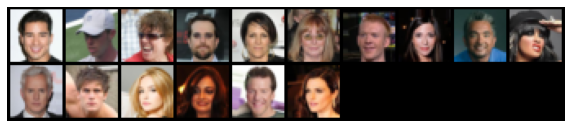

-------------------------
Starting Training Loop...

-------------------------


/pytorch/aten/src/ATen/native/TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


Epoch: 1 || 	Loss_D: 0.0315	Loss_G: 34.3595
Epoch: 2 || 	Loss_D: 0.0123	Loss_G: 29.1657
Epoch: 3 || 	Loss_D: 0.0085	Loss_G: 29.8303
Epoch: 4 || 	Loss_D: 0.0041	Loss_G: 34.2815
Epoch: 5 || 	Loss_D: 0.1201	Loss_G: 28.6061
Epoch: 6 || 	Loss_D: 0.2301	Loss_G: 34.3585
Epoch: 7 || 	Loss_D: 0.0328	Loss_G: 28.4540
Epoch: 8 || 	Loss_D: 0.0200	Loss_G: 27.2334
Epoch: 9 || 	Loss_D: 0.2824	Loss_G: 27.4563
Epoch: 10 || 	Loss_D: 0.0463	Loss_G: 27.2738
Epoch: 11 || 	Loss_D: 0.0768	Loss_G: 28.3769
Epoch: 12 || 	Loss_D: 0.1124	Loss_G: 28.4531
Epoch: 13 || 	Loss_D: 0.2595	Loss_G: 29.2342
Epoch: 14 || 	Loss_D: 0.0861	Loss_G: 27.0416
Epoch: 15 || 	Loss_D: 0.4113	Loss_G: 25.9726
Epoch: 16 || 	Loss_D: 0.1802	Loss_G: 26.4722
Epoch: 17 || 	Loss_D: 0.4217	Loss_G: 24.6995
Epoch: 18 || 	Loss_D: 0.1029	Loss_G: 26.5941
Epoch: 19 || 	Loss_D: 1.0857	Loss_G: 26.9406
Epoch: 20 || 	Loss_D: 0.7378	Loss_G: 27.6466
Epoch: 21 || 	Loss_D: 0.4512	Loss_G: 25.6108
Epoch: 22 || 	Loss_D: 0.4202	Loss_G: 28.4438
Epoch: 23 || 	Loss_

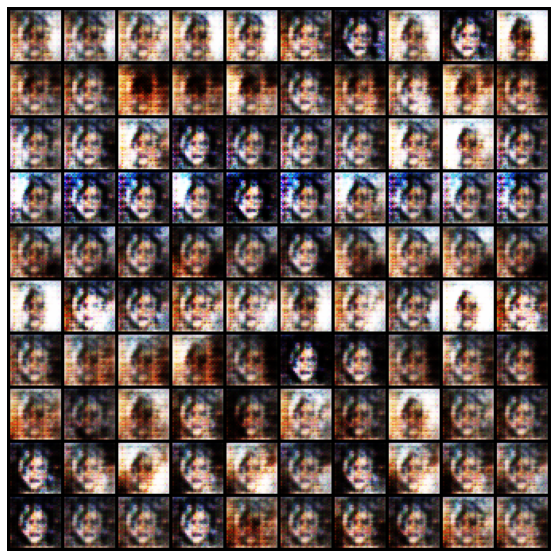

Epoch: 27 || 	Loss_D: 0.5490	Loss_G: 25.7092
Epoch: 28 || 	Loss_D: 1.0906	Loss_G: 23.9566
Epoch: 29 || 	Loss_D: 0.2694	Loss_G: 25.0308
Epoch: 30 || 	Loss_D: 0.7661	Loss_G: 23.7940
Epoch: 31 || 	Loss_D: 0.7090	Loss_G: 24.0589
Epoch: 32 || 	Loss_D: 0.4853	Loss_G: 25.0666
Epoch: 33 || 	Loss_D: 0.3163	Loss_G: 26.0969
Epoch: 34 || 	Loss_D: 0.3093	Loss_G: 26.2319
Epoch: 35 || 	Loss_D: 0.4779	Loss_G: 24.6185
Epoch: 36 || 	Loss_D: 0.7344	Loss_G: 23.3570
Epoch: 37 || 	Loss_D: 0.2463	Loss_G: 24.7861
Epoch: 38 || 	Loss_D: 0.3360	Loss_G: 26.2105
Epoch: 39 || 	Loss_D: 0.6691	Loss_G: 24.5032
Epoch: 40 || 	Loss_D: 0.2760	Loss_G: 26.3126
Epoch: 41 || 	Loss_D: 0.5025	Loss_G: 22.8863
Epoch: 42 || 	Loss_D: 0.2597	Loss_G: 26.0441
Epoch: 43 || 	Loss_D: 0.9243	Loss_G: 25.3174
Epoch: 44 || 	Loss_D: 0.9061	Loss_G: 23.1972
Epoch: 45 || 	Loss_D: 0.3885	Loss_G: 24.7378
Epoch: 46 || 	Loss_D: 1.7706	Loss_G: 22.8119
Epoch: 47 || 	Loss_D: 0.5193	Loss_G: 23.9118
Epoch: 48 || 	Loss_D: 0.5405	Loss_G: 25.5692
Epoch: 49 

Epoch: 52 || 	Loss_D: 0.2776	Loss_G: 24.9311
Epoch: 53 || 	Loss_D: 0.8964	Loss_G: 21.7061
Epoch: 54 || 	Loss_D: 0.4939	Loss_G: 23.2052
Epoch: 55 || 	Loss_D: 0.4343	Loss_G: 23.7379
Epoch: 56 || 	Loss_D: 0.7625	Loss_G: 25.8458
Epoch: 57 || 	Loss_D: 0.8463	Loss_G: 23.1783
Epoch: 58 || 	Loss_D: 0.4259	Loss_G: 23.2780
Epoch: 59 || 	Loss_D: 0.6117	Loss_G: 25.4362
Epoch: 60 || 	Loss_D: 0.5472	Loss_G: 23.8666
Epoch: 61 || 	Loss_D: 0.1467	Loss_G: 23.5367
Epoch: 62 || 	Loss_D: 0.2509	Loss_G: 23.8582
Epoch: 63 || 	Loss_D: 0.3532	Loss_G: 24.4800
Epoch: 64 || 	Loss_D: 0.1470	Loss_G: 24.4058
Epoch: 65 || 	Loss_D: 0.3532	Loss_G: 23.3620
Epoch: 66 || 	Loss_D: 0.6148	Loss_G: 23.0419
Epoch: 67 || 	Loss_D: 0.4576	Loss_G: 21.1396
Epoch: 68 || 	Loss_D: 0.2168	Loss_G: 23.2628
Epoch: 69 || 	Loss_D: 0.1513	Loss_G: 25.2219
Epoch: 70 || 	Loss_D: 0.5470	Loss_G: 21.4221
Epoch: 71 || 	Loss_D: 0.3040	Loss_G: 21.6128
Epoch: 72 || 	Loss_D: 0.2239	Loss_G: 23.2839
Epoch: 73 || 	Loss_D: 0.5913	Loss_G: 22.0248
Epoch: 74 

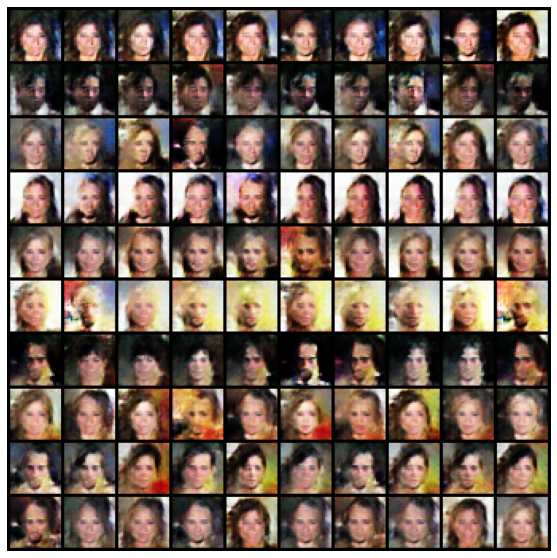

Epoch: 77 || 	Loss_D: 0.2473	Loss_G: 21.8798
Epoch: 78 || 	Loss_D: 0.0769	Loss_G: 22.8263
Epoch: 79 || 	Loss_D: 0.1358	Loss_G: 21.3967
Epoch: 80 || 	Loss_D: 0.3620	Loss_G: 21.1341
Epoch: 81 || 	Loss_D: 0.1382	Loss_G: 21.9665
Epoch: 82 || 	Loss_D: 0.3702	Loss_G: 22.6289
Epoch: 83 || 	Loss_D: 0.6413	Loss_G: 24.3593
Epoch: 84 || 	Loss_D: 0.2136	Loss_G: 20.3389
Epoch: 85 || 	Loss_D: 0.1775	Loss_G: 21.1373
Epoch: 86 || 	Loss_D: 0.1261	Loss_G: 20.4752
Epoch: 87 || 	Loss_D: 0.3282	Loss_G: 21.6832
Epoch: 88 || 	Loss_D: 0.6902	Loss_G: 19.9394
Epoch: 89 || 	Loss_D: 0.2209	Loss_G: 19.5196
Epoch: 90 || 	Loss_D: 0.1147	Loss_G: 20.4500
Epoch: 91 || 	Loss_D: 0.2997	Loss_G: 22.1952
Epoch: 92 || 	Loss_D: 0.2115	Loss_G: 21.4920
Epoch: 93 || 	Loss_D: 0.3320	Loss_G: 21.4269
Epoch: 94 || 	Loss_D: 0.3715	Loss_G: 19.5802
Epoch: 95 || 	Loss_D: 0.1639	Loss_G: 22.4228
Epoch: 96 || 	Loss_D: 0.2862	Loss_G: 18.8119
Epoch: 97 || 	Loss_D: 0.1633	Loss_G: 19.7678
Epoch: 98 || 	Loss_D: 0.5091	Loss_G: 21.5595
Epoch: 99 

Epoch: 102 || 	Loss_D: 0.1475	Loss_G: 19.1889
Epoch: 103 || 	Loss_D: 0.2080	Loss_G: 19.1282
Epoch: 104 || 	Loss_D: 0.2597	Loss_G: 21.1481
Epoch: 105 || 	Loss_D: 0.3038	Loss_G: 20.3678
Epoch: 106 || 	Loss_D: 0.1372	Loss_G: 19.9617
Epoch: 107 || 	Loss_D: 0.2048	Loss_G: 20.9420
Epoch: 108 || 	Loss_D: 0.1901	Loss_G: 20.6419
Epoch: 109 || 	Loss_D: 0.4876	Loss_G: 22.5696
Epoch: 110 || 	Loss_D: 0.1937	Loss_G: 18.8848
Epoch: 111 || 	Loss_D: 0.2070	Loss_G: 20.8420
Epoch: 112 || 	Loss_D: 0.7581	Loss_G: 22.6199
Epoch: 113 || 	Loss_D: 0.1161	Loss_G: 18.6697
Epoch: 114 || 	Loss_D: 0.1676	Loss_G: 20.2607
Epoch: 115 || 	Loss_D: 0.2604	Loss_G: 18.0625
Epoch: 116 || 	Loss_D: 0.0800	Loss_G: 21.3532
Epoch: 117 || 	Loss_D: 0.0577	Loss_G: 18.4573
Epoch: 118 || 	Loss_D: 0.1493	Loss_G: 19.9263
Epoch: 119 || 	Loss_D: 0.3771	Loss_G: 18.2149
Epoch: 120 || 	Loss_D: 0.0576	Loss_G: 16.9728
Epoch: 121 || 	Loss_D: 0.1559	Loss_G: 16.2593
Epoch: 122 || 	Loss_D: 0.1965	Loss_G: 18.3606
Epoch: 123 || 	Loss_D: 0.2000	Loss

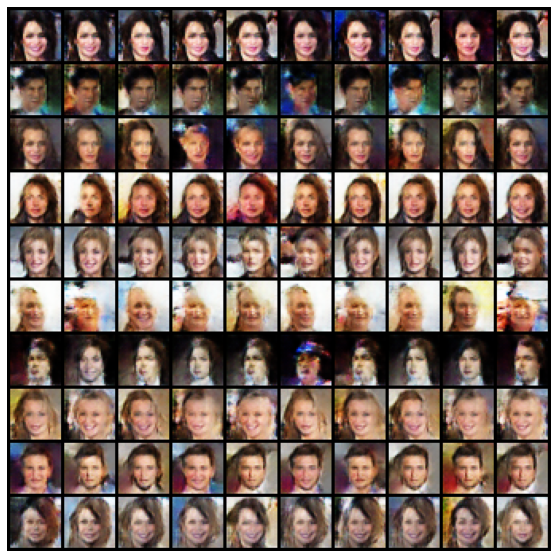

Epoch: 127 || 	Loss_D: 0.2820	Loss_G: 18.9304
Epoch: 128 || 	Loss_D: 0.1419	Loss_G: 17.9818
Epoch: 129 || 	Loss_D: 0.1065	Loss_G: 20.5971
Epoch: 130 || 	Loss_D: 0.2811	Loss_G: 16.1049
Epoch: 131 || 	Loss_D: 0.1028	Loss_G: 18.5454
Epoch: 132 || 	Loss_D: 0.0602	Loss_G: 19.3175
Epoch: 133 || 	Loss_D: 0.0645	Loss_G: 18.3892
Epoch: 134 || 	Loss_D: 0.0729	Loss_G: 19.8617
Epoch: 135 || 	Loss_D: 0.2746	Loss_G: 15.7986
Epoch: 136 || 	Loss_D: 0.1544	Loss_G: 15.4261
Epoch: 137 || 	Loss_D: 0.1799	Loss_G: 18.2131
Epoch: 138 || 	Loss_D: 0.0272	Loss_G: 18.9265
Epoch: 139 || 	Loss_D: 0.0741	Loss_G: 18.8734
Epoch: 140 || 	Loss_D: 0.0691	Loss_G: 17.9749
Epoch: 141 || 	Loss_D: 0.0625	Loss_G: 18.2251
Epoch: 142 || 	Loss_D: 0.3658	Loss_G: 20.2319
Epoch: 143 || 	Loss_D: 0.0808	Loss_G: 16.9130
Epoch: 144 || 	Loss_D: 0.0236	Loss_G: 20.2613
Epoch: 145 || 	Loss_D: 0.0860	Loss_G: 17.1672
Epoch: 146 || 	Loss_D: 0.3391	Loss_G: 13.4771
Epoch: 147 || 	Loss_D: 0.0630	Loss_G: 17.5065
Epoch: 148 || 	Loss_D: 0.4141	Loss

Epoch: 152 || 	Loss_D: 0.0865	Loss_G: 17.4670
Epoch: 153 || 	Loss_D: 0.0335	Loss_G: 18.1543
Epoch: 154 || 	Loss_D: 0.8261	Loss_G: 24.2550
Epoch: 155 || 	Loss_D: 0.1970	Loss_G: 17.7598
Epoch: 156 || 	Loss_D: 0.0553	Loss_G: 15.4255
Epoch: 157 || 	Loss_D: 0.0974	Loss_G: 16.4391
Epoch: 158 || 	Loss_D: 0.0680	Loss_G: 16.9572
Epoch: 159 || 	Loss_D: 0.0411	Loss_G: 14.6795
Epoch: 160 || 	Loss_D: 0.0783	Loss_G: 19.5711
Epoch: 161 || 	Loss_D: 0.0934	Loss_G: 18.4823
Epoch: 162 || 	Loss_D: 0.0713	Loss_G: 15.1639
Epoch: 163 || 	Loss_D: 0.0719	Loss_G: 15.4398
Epoch: 164 || 	Loss_D: 0.0574	Loss_G: 15.8168
Epoch: 165 || 	Loss_D: 0.2947	Loss_G: 15.1848
Epoch: 166 || 	Loss_D: 0.1219	Loss_G: 17.6169
Epoch: 167 || 	Loss_D: 0.0547	Loss_G: 16.1143
Epoch: 168 || 	Loss_D: 0.0592	Loss_G: 16.4016
Epoch: 169 || 	Loss_D: 0.0207	Loss_G: 17.0453
Epoch: 170 || 	Loss_D: 0.0322	Loss_G: 18.1826
Epoch: 171 || 	Loss_D: 0.1906	Loss_G: 16.0061
Epoch: 172 || 	Loss_D: 0.0265	Loss_G: 16.1103
Epoch: 173 || 	Loss_D: 0.2690	Loss

Epoch: 177 || 	Loss_D: 0.0594	Loss_G: 16.7282
Epoch: 178 || 	Loss_D: 0.0195	Loss_G: 16.5632
Epoch: 179 || 	Loss_D: 0.0577	Loss_G: 15.7802
Epoch: 180 || 	Loss_D: 0.0597	Loss_G: 15.3884
Epoch: 181 || 	Loss_D: 0.1383	Loss_G: 14.6225
Epoch: 182 || 	Loss_D: 0.0391	Loss_G: 16.4618
Epoch: 183 || 	Loss_D: 0.0279	Loss_G: 15.2744
Epoch: 184 || 	Loss_D: 0.0761	Loss_G: 14.4097
Epoch: 185 || 	Loss_D: 0.5032	Loss_G: 18.5058
Epoch: 186 || 	Loss_D: 0.0733	Loss_G: 14.7378
Epoch: 187 || 	Loss_D: 0.0349	Loss_G: 14.6644
Epoch: 188 || 	Loss_D: 0.0481	Loss_G: 14.4673
Epoch: 189 || 	Loss_D: 0.0640	Loss_G: 16.4338
Epoch: 190 || 	Loss_D: 0.0332	Loss_G: 16.0760
Epoch: 191 || 	Loss_D: 0.1405	Loss_G: 13.2566
Epoch: 192 || 	Loss_D: 0.0919	Loss_G: 13.7202
Epoch: 193 || 	Loss_D: 0.0744	Loss_G: 18.2872
Epoch: 194 || 	Loss_D: 0.1579	Loss_G: 12.7954
Epoch: 195 || 	Loss_D: 0.0496	Loss_G: 14.2344
Epoch: 196 || 	Loss_D: 0.0819	Loss_G: 17.0768
Epoch: 197 || 	Loss_D: 0.3921	Loss_G: 13.9135
Epoch: 198 || 	Loss_D: 0.1187	Loss

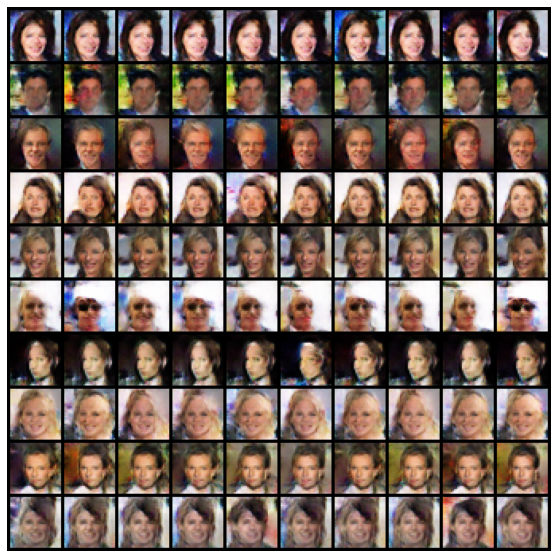

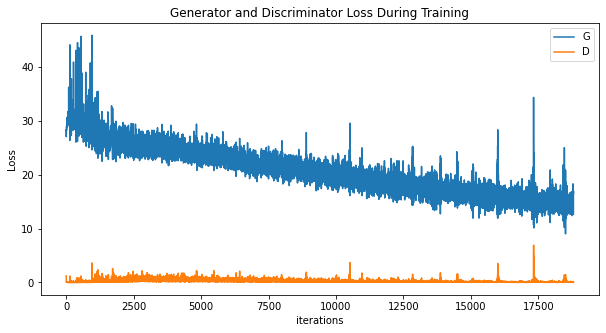

In [ ]:
# Set random seed for reproducibility.
seed = 1122
random.seed(seed)
torch.manual_seed(seed)

# Use GPU if available.
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
print(device, " will be used.\n")

num_z = 128
num_dis_c = 10
dis_c_dim = 10
num_con_c = 0

# Plot the training images.
sample_batch = next(iter(dataloader_train))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(
    sample_batch[0].to(device)[ : 100], nrow=10, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

# Initialise the network.
netG = Generator().to(device)
netG.apply(weights_init)

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

netD = DHead().to(device)
netD.apply(weights_init)


netQ = QHead().to(device)
netQ.apply(weights_init)

# Loss for discrimination between real and fake images.
criterionD = nn.BCELoss()
# Loss for discrete latent code.
criterionQ_dis = nn.CrossEntropyLoss()
# Loss for continuous latent code.
criterionQ_con = NormalNLLLoss()

# Adam optimiser is used.
optimD = optim.Adam([{'params': discriminator.parameters()}, {'params': netD.parameters()}], lr=learning_rate, betas=(beta1, beta2))
optimG = optim.Adam([{'params': netG.parameters()}, {'params': netQ.parameters()}], lr=learning_rate, betas=(beta1, beta2))

# Fixed Noise
z = torch.randn(100, num_z, 1, 1, device=device)
fixed_noise = z

if(num_dis_c != 0):
    idx = np.arange(dis_c_dim).repeat(10)
    dis_c = torch.zeros(100, num_dis_c, dis_c_dim, device=device)
    for i in range(num_dis_c):
        dis_c[torch.arange(0, 100), i, idx] = 1.0

    dis_c = dis_c.view(100, -1, 1, 1)

    fixed_noise = torch.cat((fixed_noise, dis_c), dim=1)

if(num_con_c != 0):
    con_c = torch.rand(100, num_con_c, 1, 1, device=device) * 2 - 1
    fixed_noise = torch.cat((fixed_noise, con_c), dim=1)

real_label = 1
fake_label = 0

# List variables to store results pf training.
img_list = []
G_losses = []
D_losses = []

print("-"*25)
print("Starting Training Loop...\n")
print("-"*25)

iters = 0

for epoch in range(epochs):
    for i, (data, _) in enumerate(dataloader_train):
        # Get batch size
        b_size = data.size(0)
        # Transfer data tensor to GPU/CPU (device)
        real_data = data.to(device)

        # Updating discriminator and DHead
        optimD.zero_grad()
        # Real data
        label = torch.full((b_size, ), real_label, device=device)
        output1 = discriminator(real_data)
        probs_real = netD(output1).view(-1)
        loss_real = criterionD(probs_real, label)
        # Calculate gradients.
        loss_real.backward()

        # Fake data
        label.fill_(fake_label)
        noise, idx = noise_sample(num_dis_c, dis_c_dim, num_con_c, num_z, b_size, device)
        fake_data = netG(noise)
        output2 = discriminator(fake_data.detach())
        probs_fake = netD(output2).view(-1)
        loss_fake = criterionD(probs_fake, label)
        # Calculate gradients.
        loss_fake.backward()

        # Net Loss for the discriminator
        D_loss = loss_real + loss_fake
        # Update parameters
        optimD.step()

        # Updating Generator and QHead
        optimG.zero_grad()

        # Fake data treated as real.
        output = discriminator(fake_data)
        label.fill_(real_label)
        probs_fake = netD(output).view(-1)
        gen_loss = criterionD(probs_fake, label)

        q_logits, q_mu, q_var = netQ(output)
        target = torch.LongTensor(idx).to(device)
        # Calculating loss for discrete latent code.
        dis_loss = 0
        for j in range(num_dis_c):
            dis_loss += criterionQ_dis(q_logits[:, j*10 : j*10 + 10], target[j])

        # Calculating loss for continuous latent code.
        con_loss = 0
       
        # Net loss for generator.
        G_loss = gen_loss + dis_loss + con_loss
        # Calculate gradients.
        G_loss.backward()
        # Update parameters.
        optimG.step()

        # Save the losses for plotting.
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        iters += 1

    print('Epoch: %d || \tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch+1,D_loss.item(), G_loss.item()))


    # Generate image to check performance of generator.
    if(epoch in check_epoch):
        with torch.no_grad():
            gen_data = netG(fixed_noise).detach().cpu()
        plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
        plt.show()
        #for i, (data, _) in enumerate(dataloader_test):
            # Get batch size
        #    b_size = data.size(0)
        #    # Transfer data tensor to GPU/CPU (device)
        #    real_data = data.to(device)
        #    gen_data = Generator(real_data).detach().cpu()
        #    plt.figure(figsize=(10, 10))
        #    plt.axis("off")
        #    plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
        #    plt.show()
             

print("-"*50)
print('Training finished!')
print("-"*50)

# Generate image to check performance of trained generator.
with torch.no_grad():
    gen_data = netG(fixed_noise).detach().cpu()
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))


# Plot the training losses.
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()